# Build Ensamble

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance


iterations = 200




################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)


df = pd.read_excel('PreeProcessed_Psd2.xlsx')
#df = df.drop(columns=['ReceivedDate','AccountNumber','ApplicationID','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','NR','_merge','HasCoapp'])


import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_val, y_val, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_val = gini_scorer(y_val, y_val_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_val = (gini_val + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

    return np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])


import matplotlib.pyplot as plt
import numpy as np

# Assuming train_upsampled_re and test_re dataframes are already loaded


def plotScoreDist(train_upsampled_re,val_re,test_re,feature):
    # Create masks for each category
    category1_train = train_upsampled_re[train_upsampled_re['Ever90'] == 0]
    category2_train = train_upsampled_re[train_upsampled_re['Ever90'] == 1]
    category1_val = val_re[val_re['Ever90'] == 0]
    category2_val = val_re[val_re['Ever90'] == 1]
    category1_test = test_re[test_re['Ever90'] == 0]
    category2_test = test_re[test_re['Ever90'] == 1]

    # Create a figure and axis
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 2 columns

    # Plot histograms for train data
    axs[0].hist(category1_train[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 0', density=True)
    axs[0].hist(category2_train[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 1', density=True)
    axs[0].set_title('Train Default Probabilities Hist')
    axs[0].set_xlabel('Probability of Default')
    axs[0].set_ylabel('Density')
    axs[0].legend(loc='upper right')
    axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot histograms for test data
    axs[1].hist(category1_val[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 0', density=True)
    axs[1].hist(category2_val[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 1', density=True)
    axs[1].set_title('Validation Default Probabilities Hist')
    axs[1].set_xlabel('Probability of Default')
    axs[1].set_ylabel('Density')
    axs[1].legend(loc='upper right')
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Plot histograms for test data
    axs[2].hist(category1_test[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 0', density=True)
    axs[2].hist(category2_test[feature], bins=30, edgecolor='k', alpha=0.5, label='Ever90 = 1', density=True)
    axs[2].set_title('Test Default Probabilities Hist')
    axs[2].set_xlabel('Probability of Default')
    axs[2].set_ylabel('Density')
    axs[2].legend(loc='upper right')
    axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()

    #print(f"Mean Probability for Train Data: {np.mean(train_upsampled_re[feature])}")
    #print(f"Mean Probability for Test Data: {np.mean(test_re[feature])}")



def LevelOneScore(model , train,val, test ,df, optimal_features ,plot = True):

    forforsta = df[['Ever90']+list(optimal_features)]

    # Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
    preprocessor = DataPreprocessor(forforsta)

    ## Scalle
    (Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features),scale=False)

    y_train_pred_proba = model.predict_proba(Xtrain)[:, 1]
    y_val_pred_proba = model.predict_proba(Xval)[:, 1]
    y_test_pred_proba = model.predict_proba(Xtest)[:, 1]

    # Plot for both the training and validation sets
    if plot == True:
        plot_gini(model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")


    return np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])



In [2]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
# Assuming `df`, `preprocessor`, `train`, `val`, `test`, `gini_score`, and `plot_gini` are predefined




# Reading the train.csv file into a DataFrame
train = pd.read_csv('train.csv')

# Reading the train.csv file into a DataFrame
val = pd.read_csv('val.csv')

# Reading the test.csv file into a DataFrame
test = pd.read_csv('test.csv')

df = pd.concat([train,val,test])

In [3]:
train

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-12-28,8513891,0,7108033239,2023-01-09,500000,1,1,1,0,...,53052.0,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0
1,2023-01-09,8528123,0,8703224843,2023-01-16,500000,1,1,1,0,...,111.8,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
3,2022-03-03,8201314,0,8808020989,2022-03-15,276000,1,1,1,0,...,150.5,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0
4,2022-10-10,8420404,0,8701212469,2022-11-28,156500,1,1,0,0,...,130.1,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2367,2022-11-21,8472026,0,7202121708,2022-11-24,500000,0,2,1,0,...,23872.0,165.2,47.0,117.4,153.1,321626,16749,108869,217967,0
2368,2023-04-22,8651069,0,8201027912,2023-05-02,300000,1,1,1,1,...,16930.0,133.1,95.0,142.3,136.2,223432,36201,74311,153202,0
2369,2022-11-14,8462708,0,9501047311,2022-11-21,500000,0,2,1,0,...,140.9,218.6,233.7,528243.0,85423.0,256788,482350,0,0,0
2370,2022-12-30,8516099,0,9711303983,2023-01-05,500000,1,1,1,0,...,269.3,236.8,376.6,860834.0,119665.0,246092,641294,0,0,0


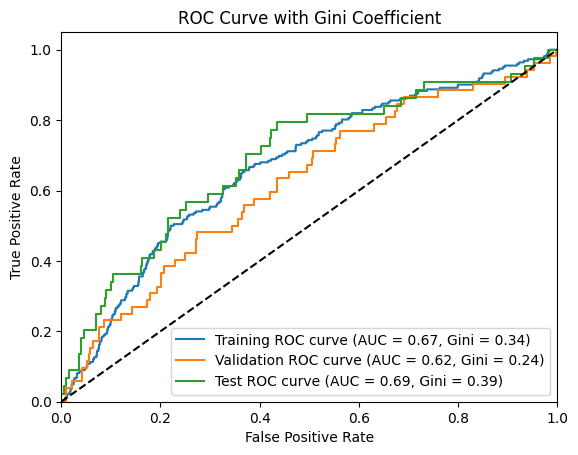

['avg3Months_CashWithdrawal',
 'avg3Months_Loan',
 'avg3Months_Salary',
 'avg6Months_Gambling',
 'count_Loan',
 'sum_Salary',
 'CashWithdrawal_sum12Months',
 'Gaming_count3Months',
 'InstallmentPayment_count12Months',
 'count_PassiveIncome']

In [4]:
import joblib

path = "../../2. Python/Finished Models"
os.chdir(path)


# Load the model and optimal features
lg_model_1 = joblib.load('lg_model_1.pkl')
lg_optimal_features = joblib.load('optimal_features_lg_model_1.pkl')

lg_score =  LevelOneScore(lg_model_1 , train,val, test ,df, lg_optimal_features)

lg_optimal_features


In [7]:
train
lg_model_1.predict_proba(train[lg_optimal_features])[:, 1]

array([0.63658655, 0.39197518, 0.51594849, ..., 0.44529672, 0.61783698,
       0.45131592])

In [5]:
lg_model_1.intercept_

array([0.25339811])

In [4]:
lg_optimal_features

array(['avg3Months_CashWithdrawal', 'avg3Months_Loan',
       'avg3Months_Salary', 'avg6Months_Gambling', 'count_Loan',
       'sum_Salary', 'CashWithdrawal_sum12Months', 'Gaming_count3Months',
       'InstallmentPayment_count12Months', 'count_PassiveIncome'],
      dtype='<U33')

In [5]:
lg_model_1.coef_[0]

array([ 0.08595968,  0.14332106, -0.07663129,  0.14881695,  0.3978634 ,
       -0.20848859,  0.04490195,  0.15609527,  0.07131207, -0.1552356 ])

## Final

In [14]:
train['LG_Model'] = lg_score[:len(train)] 
val['LG_Model'] = lg_score[:len(val)] 
test['LG_Model'] = lg_score[:len(test)] 

done = pd.concat([train,val,test])


done

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge,LG_Model
0,2022-12-28,8513891,0,7108033239,2023-01-09,500000,1,1,1,0,...,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0,0.636587
1,2023-01-09,8528123,0,8703224843,2023-01-16,500000,1,1,1,0,...,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0,0.391975
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0,0.515948
3,2022-03-03,8201314,0,8808020989,2022-03-15,276000,1,1,1,0,...,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0,0.461869
4,2022-10-10,8420404,0,8701212469,2022-11-28,156500,1,1,0,0,...,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0,0.447378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2022-10-02,8409647,0,9501031414,2022-10-07,228000,1,1,0,0,...,100.0,694.6,282121.0,58860.0,141994,206258,0,0,0,0.693756
482,2023-03-21,8614945,0,8409200352,2023-03-23,300000,1,1,0,0,...,516413.0,123722.0,324995.0,431425.0,0,0,0,0,0,0.437938
483,2022-09-02,8370396,0,8803083602,2022-10-17,145000,1,1,0,0,...,318000.0,38583.0,133955.0,220786.0,0,0,0,0,0,0.403366
484,2023-04-20,8649594,0,310031521,2023-04-24,285000,0,2,1,0,...,235.6,119.1,260.5,237.3,623759,101160,415025,541105,0,0.629150


In [15]:
done_cali = done[['Ever90','LG_Model']]

In [18]:
# Import necessary libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Prepare the data
done_cali = done[['Ever90', 'LG_Model']]
X = done_cali['LG_Model'].values.reshape(-1, 1)
y = done_cali['Ever90']

# Fit the logistic regression model
lg_model_cali = LogisticRegression()
lg_model_cali.fit(X, y)

# Make predictions on the same dataset
y_pred = lg_model_cali.predict(X)
y_pred_proba = lg_model_cali.predict_proba(X)[:, 1]


train['Calibrated'] = y_pred_proba[:len(train)] 
val['Calibrated'] = y_pred_proba[:len(val)] 
test['Calibrated'] = y_pred_proba[:len(test)] 

done = pd.concat([train,val,test])


# Strategy - Here the Train & Validation is not something that one should take strategic decision on since they have been use for problem optimisation, 

However since Val scores as high as Test (GINI) we can assue they are corresponding eachother

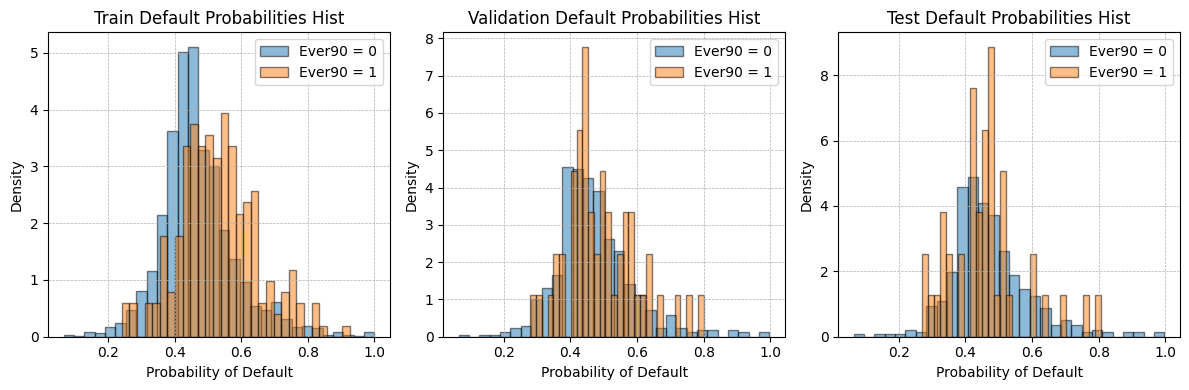

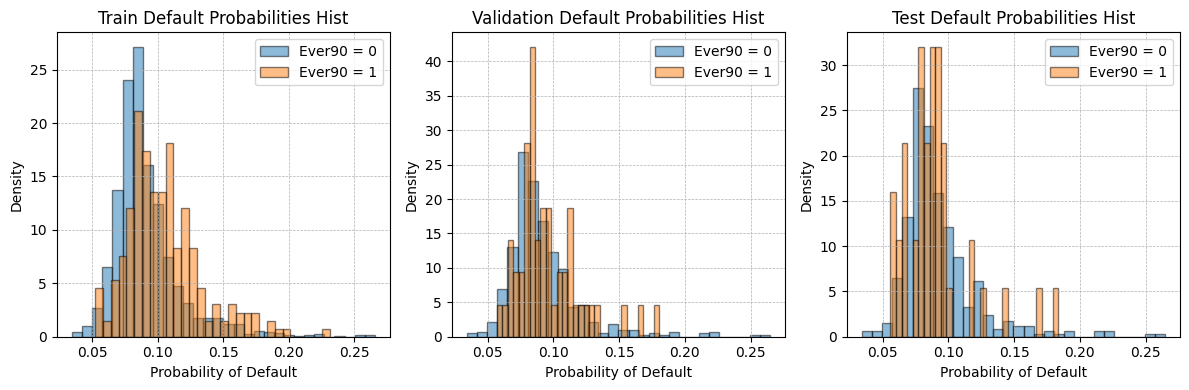

In [17]:
plotScoreDist(train,val,test,'LG_Model')

plotScoreDist(train,val,test,'Calibrated')

In [69]:




def getReason(logreg,df):

    """ Calculate Normalized Feature Contribution to each score """

    coefNweight = logreg.coef_[0] * df
    abs_coefNweight = logreg.coef_[0] * df
    abs_coefNweight['sum_absCoef'] = abs_coefNweight.sum(axis=1)

    relative = pd.DataFrame()

    for i in abs_coefNweight.columns:
        if i != 'sum_absCoef': relative[i] = coefNweight[i] / abs_coefNweight['sum_absCoef']


    relative['score']  = lg_model_1.predict_proba(inp[lg_optimal_features])[:, 1]



    return relative 

relative = getReason(lg_model_1,inp)

In [31]:
inp = df[lg_optimal_features]

df = inp 



def CalculateFeatureScore(lg_model_1,df):

    coefNweight = lg_model_1.coef_[0] * df
    coefNweight['Intercept'] = float(lg_model_1.intercept_)
    coefNweight['sum_absCoef'] = coefNweight.sum(axis=1)

    relative = pd.DataFrame()

    for i in coefNweight.columns:
        if i not in ['sum_absCoef']: relative[i] = coefNweight[i] / np.abs(coefNweight['sum_absCoef'])

    score  = pd.DataFrame(lg_model_1.predict_proba(inp[lg_optimal_features])[:, 1])
    relative['Calibrated_Score']  = lg_model_cali.predict_proba(score.values.reshape(-1, 1))[:, 1]


    for i in coefNweight.columns:
        if i not in ['sum_absCoef','Calibrated_Score']: relative[i] = relative[i] * relative['Calibrated_Score']

    return relative



In [32]:
CalculateFeatureScore(lg_model_1,df)

,avg3Months_CashWithdrawal,avg3Months_Loan,avg3Months_Salary,avg6Months_Gambling,count_Loan,sum_Salary,CashWithdrawal_sum12Months,Gaming_count3Months,InstallmentPayment_count12Months,count_PassiveIncome,Intercept,Calibrated_Score
0,0.005596,0.000093,-0.000000,0.002721,0.045806,-0.000000,0.000118,0.013575,0.002312,-0.000000,0.057925,0.128145
1,0.000435,0.002313,-0.013152,0.003431,0.004836,-0.034495,0.004914,0.000064,0.000029,-0.085362,0.042813,0.074174
2,0.046182,0.081599,-0.226136,0.010851,0.396684,-0.690768,0.000043,0.089640,0.000000,-0.000000,0.390163,0.098258
3,0.032077,0.000000,-0.102861,0.011589,0.032591,-0.282383,0.077421,0.000248,0.000071,-0.000000,0.144250,0.086996
4,0.000000,0.000000,-0.055354,0.001227,0.022812,-0.154296,0.000252,0.000000,0.000208,-0.000000,0.100968,0.084182
...,...,...,...,...,...,...,...,...,...,...,...,...
481,0.000000,0.000000,-0.000000,0.011897,0.028283,-0.056874,0.000000,0.000000,0.048082,-0.000000,0.083455,0.114843
482,0.002311,0.014666,-0.079820,0.122724,0.021682,-0.225447,0.008183,0.000048,0.000124,-0.044155,0.095964,0.083721
483,0.000853,0.003783,-0.066908,0.003618,0.050355,-0.164351,0.000362,0.000010,0.000105,-0.000000,0.089149,0.083023
484,0.000000,0.000000,-0.027499,0.002093,0.003587,-0.060232,0.000000,0.000141,0.000000,-0.019482,0.031756,0.069636


In [27]:
relative

,avg3Months_CashWithdrawal,avg3Months_Loan,avg3Months_Salary,avg6Months_Gambling,count_Loan,sum_Salary,CashWithdrawal_sum12Months,Gaming_count3Months,InstallmentPayment_count12Months,count_PassiveIncome,Intercept,Calibrated_Score
0,0.005596,0.000093,-0.000000,0.002721,0.045806,-0.000000,0.000118,0.013575,0.002312,-0.000000,0.057925,0.128145
1,-0.000435,-0.002313,0.013152,-0.003431,-0.004836,0.034495,-0.004914,-0.000064,-0.000029,0.085362,-0.042813,0.074174
2,0.046182,0.081599,-0.226136,0.010851,0.396684,-0.690768,0.000043,0.089640,0.000000,-0.000000,0.390163,0.098258
3,-0.032077,-0.000000,0.102861,-0.011589,-0.032591,0.282383,-0.077421,-0.000248,-0.000071,0.000000,-0.144250,0.086996
4,-0.000000,-0.000000,0.055354,-0.001227,-0.022812,0.154296,-0.000252,-0.000000,-0.000208,0.000000,-0.100968,0.084182
...,...,...,...,...,...,...,...,...,...,...,...,...
481,0.000000,0.000000,-0.000000,0.011897,0.028283,-0.056874,0.000000,0.000000,0.048082,-0.000000,0.083455,0.114843
482,-0.002311,-0.014666,0.079820,-0.122724,-0.021682,0.225447,-0.008183,-0.000048,-0.000124,0.044155,-0.095964,0.083721
483,-0.000853,-0.003783,0.066908,-0.003618,-0.050355,0.164351,-0.000362,-0.000010,-0.000105,0.000000,-0.089149,0.083023
484,-0.000000,-0.000000,0.027499,-0.002093,-0.003587,0.060232,-0.000000,-0.000141,-0.000000,0.019482,-0.031756,0.069636


In [33]:

see = relative

see.drop(columns=['Calibrated_Score']).sum(axis=1)

0      0.128145
1      0.074174
2      0.098258
3      0.086996
4      0.084182
         ...   
481    0.114843
482    0.083721
483    0.083023
484    0.069636
485    0.095254
Length: 3453, dtype: float64

In [7]:
relative.sum(axis=1)

0      1.273173
1      0.783950
2      1.031897
3      0.923738
4      0.894756
         ...   
481    1.172607
482    0.889913
483    0.882552
484    0.729106
485    1.004176
Length: 3453, dtype: float64

In [11]:

relative['Score']  = lg_model_1.predict_proba(inp[lg_optimal_features])[:, 1]

for i in coefNweight.columns:
    if i not in ['sum_absCoef','Score']: relative[i] = relative[i] * relative['Score']


In [12]:
relative

,avg3Months_CashWithdrawal,avg3Months_Loan,avg3Months_Salary,avg6Months_Gambling,count_Loan,sum_Salary,CashWithdrawal_sum12Months,Gaming_count3Months,InstallmentPayment_count12Months,count_PassiveIncome,Intercept,Score
0,0.027800,0.000460,-0.000000,0.013515,0.227550,-0.000000,0.000584,0.067434,0.011487,-0.000000,0.287756,0.636587
1,-0.002297,-0.012221,0.069500,-0.018130,-0.025559,0.182289,-0.025967,-0.000338,-0.000155,0.451099,-0.226246,0.391975
2,0.242501,0.428471,-1.187423,0.056975,2.082959,-3.627176,0.000225,0.470696,0.000000,-0.000000,2.048721,0.515948
3,-0.170302,-0.000000,0.546097,-0.061528,-0.173030,1.499202,-0.411039,-0.001314,-0.000379,0.000000,-0.765838,0.461869
4,-0.000000,-0.000000,0.294174,-0.006522,-0.121234,0.819990,-0.001340,-0.000000,-0.001105,0.000000,-0.536585,0.447378
...,...,...,...,...,...,...,...,...,...,...,...,...
481,0.000000,0.000000,-0.000000,0.060736,0.144392,-0.290354,0.000000,0.000000,0.245472,-0.000000,0.426057,0.586303
482,-0.012281,-0.077949,0.424227,-0.652251,-0.115233,1.198204,-0.043492,-0.000254,-0.000660,0.234673,-0.510027,0.444957
483,-0.004536,-0.020109,0.355624,-0.019229,-0.267643,0.873545,-0.001924,-0.000052,-0.000560,0.000000,-0.473838,0.441276
484,-0.000000,-0.000000,0.143962,-0.010959,-0.018781,0.315323,-0.000000,-0.000736,-0.000000,0.101992,-0.166248,0.364553


0      0.636587
1      0.391975
2      0.515948
3      0.461869
4      0.447378
         ...   
481    0.586303
482    0.444957
483    0.441276
484    0.364553
485    0.502088
Length: 3453, dtype: float64

In [86]:
abs_coefNweight

,avg3Months_CashWithdrawal,avg3Months_Loan,avg3Months_Salary,avg6Months_Gambling,count_Loan,sum_Salary,CashWithdrawal_sum12Months,Gaming_count3Months,InstallmentPayment_count12Months,count_PassiveIncome,Intercept,sum_absCoef
0,0.024480,0.000405,-0.000000,0.011902,0.200381,-0.000000,0.000514,0.059383,0.010116,-0.000000,0.253398,0.560579
1,0.002573,0.013688,-0.077841,0.020306,0.028626,-0.204166,0.029084,0.000379,0.000174,-0.505237,0.253398,-0.439017
2,0.029994,0.052996,-0.146868,0.007047,0.257633,-0.448631,0.000028,0.058219,0.000000,-0.000000,0.253398,0.063816
3,0.056349,0.000000,-0.180691,0.020358,0.057252,-0.496051,0.136003,0.000435,0.000125,-0.000000,0.253398,-0.152822
4,0.000000,0.000000,-0.138921,0.003080,0.057252,-0.387234,0.000633,0.000000,0.000522,-0.000000,0.253398,-0.211271
...,...,...,...,...,...,...,...,...,...,...,...,...
481,0.000000,0.000000,-0.000000,0.036123,0.085878,-0.172689,0.000000,0.000000,0.145995,-0.000000,0.253398,0.348705
482,0.006102,0.038728,-0.210770,0.324060,0.057252,-0.595307,0.021608,0.000126,0.000328,-0.116593,0.253398,-0.221069
483,0.002426,0.010754,-0.190180,0.010283,0.143129,-0.467152,0.001029,0.000028,0.000299,-0.000000,0.253398,-0.235985
484,0.000000,0.000000,-0.219429,0.016704,0.028626,-0.480621,0.000000,0.001122,0.000000,-0.155458,0.253398,-0.555658


In [49]:

# Binning structure


binsV = [0, 0.055, 0.075 ,0.11, 0.15, 1] 

done['Probability_Bins'] = pd.cut(done['Calibrated'], bins=binsV, labels=False)

grouped_mean = done.groupby('Probability_Bins')[('Calibrated')].mean()

# Group by Probability_Bins and Ever90, then count the number of occurrences
grouped_counts = done.groupby(['Probability_Bins', 'Ever90']).size().unstack().reset_index()


# Replace NaN with 0 if any
grouped_counts.fillna(0, inplace=True)

# Avoid division by zero by adding a small number to the denominator
epsilon = 1e-10 
grouped_counts['90+'] = grouped_counts[1] / ((grouped_counts[0] + grouped_counts[1] +epsilon))

grouped_counts['Expected_PD'] = list(grouped_mean)



grouped_counts

Ever90,Probability_Bins,0,1,90+,Expected_PD
0,0,63,3,0.045455,0.048365
1,1,669,39,0.055085,0.068028
2,2,1925,185,0.087678,0.088854
3,3,352,67,0.159905,0.124470
4,4,126,24,0.160000,0.180631


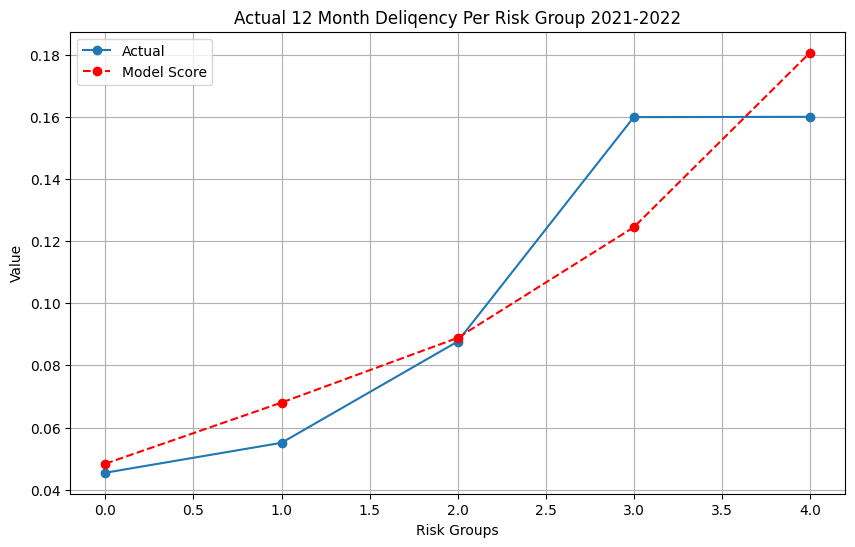

In [50]:



# Create plot
plt.figure(figsize=(10,6))
plt.plot(grouped_counts.Probability_Bins, grouped_counts['90+'], marker='o', label='Actual')
plt.plot(grouped_counts.Probability_Bins, grouped_counts.Expected_PD, marker='o', linestyle='--', color='red', label='Model Score')
plt.xlabel('Risk Groups')
plt.ylabel('Value')
plt.title('Actual 12 Month Deliqency Per Risk Group 2021-2022')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
lg_optimal_features

array(['avg3Months_CashWithdrawal', 'avg3Months_Loan',
       'avg3Months_Salary', 'avg6Months_Gambling', 'count_Loan',
       'sum_Salary', 'CashWithdrawal_sum12Months', 'Gaming_count3Months',
       'InstallmentPayment_count12Months', 'count_PassiveIncome'],
      dtype='<U33')

In [ ]:
lg_model.coef_

array([[2.48180895]])

## Feature Importance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def scale_df(df, features):
    """
    Scale the features of the DataFrame.
    """
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[features] = scaler.fit_transform(df[features])
    return df_scaled

# Assuming df is your DataFrame, and lg_model_1 is your trained logistic regression model

# Define your optimal features
lg_optimal_features = np.array(['avg_Loan', 'avg3Months_CashWithdrawal', 'avg3Months_Deposit',
       'avg3Months_Loan', 'avg3Months_Salary', 'avg6Months_Gambling',
       'count_Loan', 'sum_Salary', 'trend_Gaming', 'Gaming_count3Months',
       'InstallmentPayment_count12Months', 'DirectDebit_sum12Months',
       'count_PassiveIncome'])

# Scale the DataFrame
df_scaled = scale_df(df, lg_optimal_features)

# Get the coefficients of the logistic regression model
coefficients = lg_model_1.coef_[0]

# Create a DataFrame to hold the features and their corresponding coefficients
feature_importance_df = pd.DataFrame({
    'Feature': lg_optimal_features,
    'Coefficient': coefficients
})

# Extract the list of feature names
features = list(feature_importance_df['Feature'])

# Calculate the mean of each feature, ignoring zeros
mean_values = df_scaled[features].replace(0, np.nan).mean()

# Multiply the mean values by the coefficients
importance_values = mean_values * coefficients

# Create a DataFrame to hold the feature importance values
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance_values
})

# Sort the DataFrame by the absolute value of the importance in descending order
importance_df['Abs_Importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by='Abs_Importance', ascending=False)

# Plot the sorted feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center', color='skyblue')
plt.xlabel('Importance (Mean * Coefficient)')
plt.title('Feature Importance for Logistic Regression Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()


ValueError: All arrays must be of the same length

In [ ]:
work = df[lg_optimal_features]

In [ ]:
work

,avg_Loan,avg3Months_CashWithdrawal,avg3Months_Deposit,avg3Months_Loan,avg3Months_Salary,avg6Months_Gambling,count_Loan,sum_Salary,trend_Gaming,Gaming_count3Months,InstallmentPayment_count12Months,DirectDebit_sum12Months,count_PassiveIncome
0,177,666,800,69,0,228,7,0,0.0,4233,2500,0.0,0
1,500,70,1461,2333,10041,389,1,115369,-65.5,27,43,5091.0,13
2,5868,816,6998,9033,18945,135,9,253510,-100.0,4150,0,0.9,0
3,171,1533,342,0,23308,390,2,280306,153.9,31,31,0.0,0
4,34,0,819,0,17920,59,2,218816,0.0,0,129,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,785,0,0,0,0,692,3,97582,-86.1,0,36081,0.0,0
482,13914,166,7823,6601,27188,6208,2,336393,255.7,9,81,33525.0,3
483,1352,66,1262,1833,24532,197,5,263976,-63.3,2,74,0.0,0
484,128,0,3919,0,28305,320,1,271587,0.0,80,0,0.0,4


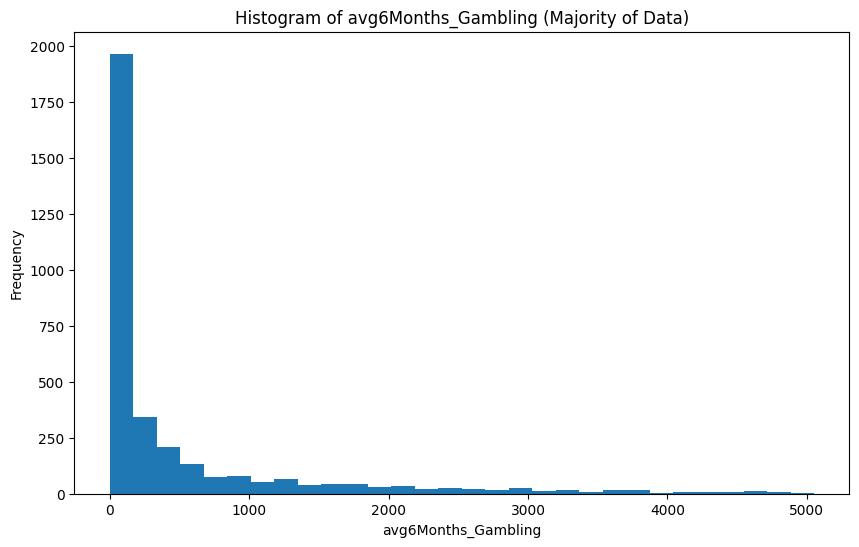

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and avg_Loan is the column of interest

def gethist(df, var):
    # Calculate the interquartile range (IQR)
    Q1 = df[var].quantile(0.7)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1

    # Define the range to plot
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the data to include only the majority range
    filtered_data = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    filtered_data[var].hist(bins=30)
    plt.title(f'Histogram of {var} (Majority of Data)')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()

var = 'avg6Months_Gambling'   

gethist(df, var)


In [ ]:
np.mean(work[work.avg6Months_Gambling> 5000].avg6Months_Gambling)

11902.17808219178

In [ ]:
np.mean(work.avg6Months_Gambling)

956.9377353026354